In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Get the original magma colormap
magma = plt.cm.get_cmap('magma', 256)

# Convert to array and prepend grey
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])  # RGBA for light grey

# Combine: grey for near-zero, then rest of magma
new_colors = np.vstack((grey, magma_colors[20:]))  # skip darkest part of magma
custom_cmap1 = ListedColormap(new_colors)

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_12504\2828510362.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma = plt.cm.get_cmap('magma', 256)


In [3]:
def preprocess_adata(adata):

    # Ensure unique gene names to prevent reindexing errors
    adata.var_names_make_unique()
    
    # Mark mitochondrial and ribosomal genes
    adata.var['mt'] = adata.var_names.str.startswith("MT-")
    
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=['mt'],
        percent_top=None,
        log1p=False,
        inplace=True
    )

    # normalize
    sc.pp.normalize_total(adata, target_sum=10000)
    sc.pp.log1p(adata)
    
    return adata

In [4]:
# CO_STR
adata_CO = sc.read_mtx('CO_STR.scp.matrix.mtx').T
genes_CO = pd.read_csv('CO_STR.scp.features.tsv', header=None, sep='\t')
adata_CO.var.index = genes_CO[1].values
barcodes_CO = pd.read_csv('CO_STR.scp.barcodes.tsv', header=None, sep='\t')
adata_CO.obs.index = barcodes_CO[0].values

In [5]:
adata_CO = preprocess_adata(adata_CO)
gadata_CO = adata_CO.copy()

In [6]:
adata_CO.obs['Sample.ID'] = adata_CO.obs_names.str.split('_').str[0]

In [7]:
samples_df = pd.read_excel('mmc2.xlsx', sheet_name='Samples')
samples_info = pd.DataFrame({
    "Sample.ID": samples_df.iloc[:, 0],   # Sample.ID
    "Condition": samples_df.iloc[:, 2]    # Condition (Heal, NonI, Infl)
})

In [8]:
sample_to_condition = dict(zip(samples_info['Sample.ID'], samples_info['Condition']))
adata_CO.obs['condition'] = adata_CO.obs['Sample.ID'].map(sample_to_condition)

In [9]:
print(adata_CO.obs[['Sample.ID', 'condition']].head())

                           Sample.ID condition
N105446_L-GTGTGGCTCCGTCAAA   N105446      NonI
N105446_L-CAATACGAGTCCCTAA   N105446      NonI
N105446_L-CCCTGATAGTGTTCCA   N105446      NonI
N105446_L-CATTGTTAGAGCCCAA   N105446      NonI
N105446_L-TCCATGCGTTCGTTCC   N105446      NonI


In [10]:
sc.pp.highly_variable_genes(adata_CO, flavor='seurat', n_top_genes = 2500)
adata_CO.raw = adata_CO.copy()
adata_CO = adata_CO[:, adata_CO.var.highly_variable].copy()

C:\Anaconda3\envs\NIM_Kim\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


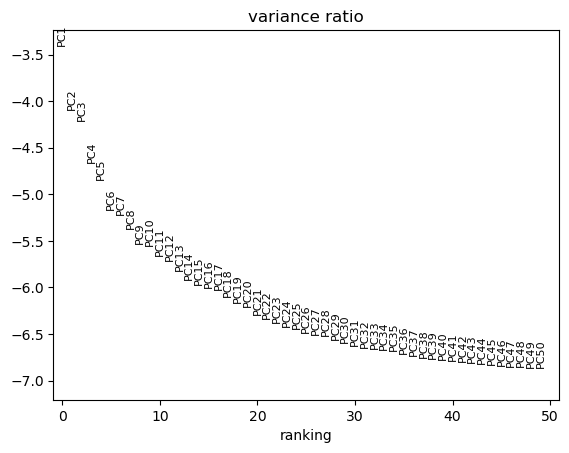

In [11]:
sc.pp.scale(adata_CO, max_value=10)
sc.tl.pca(adata_CO, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_CO, log=True, n_pcs = 50)

In [12]:
sc.external.pp.harmony_integrate(adata_CO, key='Sample.ID', max_iter_harmony = 20)
sc.pp.neighbors(adata_CO, n_neighbors = 30, n_pcs = 50, use_rep='X_pca_harmony')
sc.tl.umap(adata_CO)

2025-07-22 15:26:32,019 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-22 15:26:41,477 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-22 15:26:41,884 - harmonypy - INFO - Iteration 1 of 20
2025-07-22 15:27:22,940 - harmonypy - INFO - Iteration 2 of 20
2025-07-22 15:28:03,013 - harmonypy - INFO - Iteration 3 of 20
2025-07-22 15:28:43,185 - harmonypy - INFO - Iteration 4 of 20
2025-07-22 15:29:23,309 - harmonypy - INFO - Iteration 5 of 20
2025-07-22 15:30:00,705 - harmonypy - INFO - Iteration 6 of 20
2025-07-22 15:30:39,411 - harmonypy - INFO - Iteration 7 of 20
2025-07-22 15:31:06,433 - harmonypy - INFO - Converged after 7 iterations
C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_12504\866931948.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_CO, resolution = 1.0)


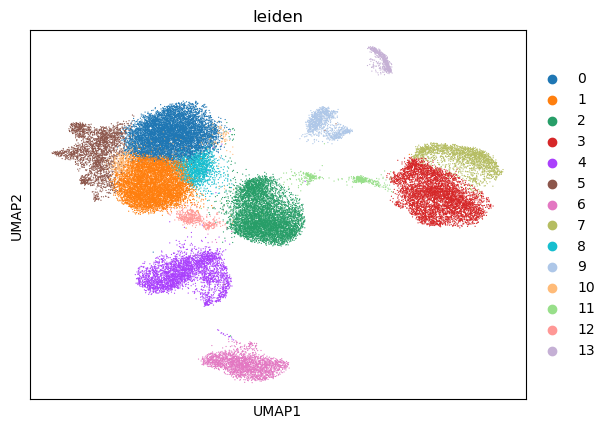

In [13]:
sc.tl.leiden(adata_CO, resolution = 1.0)
sc.pl.umap(adata_CO, color=['leiden'])

In [14]:
marker_gene = pd.read_excel("mmc3.xlsx")
stromal_marker = marker_gene[marker_gene["Compartment"] == "Stromal"]
stromal_marker = stromal_marker[['Cell subset name', 'Markers']]
stromal_marker

,Cell subset name,Markers
0,Activated fibroblasts CCL19+ ADAMADEC1+,"['CCL19', 'ADAMDEC1']"
6,Endothelial cells CA4+ CD36+,"['CD4', 'CD36']"
7,Endothelial cells CD36+,"['CD36', 'RBP7', 'TMEM88', 'PLVAP', 'COL15A1']"
8,Endothelial cells DARC+,"['DARC', 'SELE', 'C2CD4B', 'GPR126', 'CPE']"
9,Endothelial cells LTC4S+ SEMA3G+,"['SEMA3G', 'LTC4S', 'C10orf10']"
19,Fibroblasts ADAMDEC1+,"['CCL11', 'ADAMDEC1', 'CCL13', 'HAPLN1']"
20,Fibroblasts KCNN3+ LY6H+,"['KCNN3', 'LY6H', 'DPT', 'C7', 'SCN7A']"
21,Fibroblasts NPY+ SLITRK6+,"['NPY', 'SLITRK6', 'F3', 'EDNRB', 'NSG1']"
22,Fibroblasts SFRP2+ SLPI+,"['SLPI', 'SFRP2', 'IGFBP6', 'MFAP5']"
23,Fibroblasts SMOC2+ PTGIS+,"['SMOC2', 'PTGIS', 'F3', 'PCSK6', 'ADAMTSL3',..."


In [15]:
import ast
stromal_marker['Markers'] = stromal_marker['Markers'].apply(ast.literal_eval)

In [18]:
stromal_marker_long = stromal_marker.explode('Markers')
stromal_marker_long.rename(columns={'Cell subset name': 'cell_type', 'Markers': 'gene'}, inplace=True)
print(stromal_marker.head())
print(stromal_marker_long.head())

                           Cell subset name  \
0  Activated fibroblasts CCL19+ ADAMADEC1+    
6             Endothelial cells CA4+ CD36+    
7                  Endothelial cells CD36+    
8                  Endothelial cells DARC+    
9         Endothelial cells LTC4S+ SEMA3G+    

                                Markers  
0                     [CCL19, ADAMDEC1]  
6                           [CD4, CD36]  
7  [CD36, RBP7, TMEM88, PLVAP, COL15A1]  
8     [DARC, SELE, C2CD4B, GPR126, CPE]  
9             [SEMA3G, LTC4S, C10orf10]  
                                  cell_type      gene
0  Activated fibroblasts CCL19+ ADAMADEC1+      CCL19
0  Activated fibroblasts CCL19+ ADAMADEC1+   ADAMDEC1
6             Endothelial cells CA4+ CD36+        CD4
6             Endothelial cells CA4+ CD36+       CD36
7                  Endothelial cells CD36+       CD36


In [29]:
def auto_celltype_annotation(adata, marker_df, groupby='leiden', top_n=500):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    clusters = adata.obs[groupby].unique()
    cluster_to_type = {}

    for cluster in clusters:
        degs = sc.get.rank_genes_groups_df(adata, group=cluster, pval_cutoff=None)
        top_genes = set(degs['names'].head(top_n))  # top_n 늘려줌

        scores = {}
        matched_genes = {}

        for cell_type in marker_df['cell_type'].unique():
            markers = set(marker_df.loc[marker_df['cell_type'] == cell_type, 'gene'])
            matched = top_genes & markers
            scores[cell_type] = len(matched)
            matched_genes[cell_type] = matched

        best_match = max(scores, key=scores.get)
        cluster_to_type[cluster] = best_match

        print(f"\n[Cluster {cluster}]")
        print(f"  Best match: {best_match}")
        print(f"  Matched marker genes: {', '.join(matched_genes[best_match]) if matched_genes[best_match] else 'None'}")

    adata.obs['cell_type'] = adata.obs[groupby].map(cluster_to_type)
    return cluster_to_type

In [30]:
cluster_to_type = auto_celltype_annotation(adata_CO, stromal_marker_long, groupby='leiden', top_n=50)
print(cluster_to_type)


[Cluster 0]
  Best match: Fibroblasts ADAMDEC1+
  Matched marker genes: CCL11, CCL13, HAPLN1, ADAMDEC1

[Cluster 3]
  Best match: Endothelial cells CD36+
  Matched marker genes: PLVAP, CD36, RBP7, TMEM88

[Cluster 13]
  Best match: Lymphatics
  Matched marker genes: TFPI, LYVE1, MMRN1, PPFIBP1, CCL21

[Cluster 7]
  Best match: Endothelial cells DARC+
  Matched marker genes: CPE, DARC, GPR126

[Cluster 9]
  Best match: Pericytes HIGD1B+ STEAP4+
  Matched marker genes: HIGD1B, STEAP4, NOTCH3, COX4I2

[Cluster 6]
  Best match: Glial cells
  Matched marker genes: GPM6B, S100B, LGI4, NRXN1, SCN7A, CDH19, SPP1, PLP1

[Cluster 4]
  Best match: Myofibroblasts HHIP+ NPNT+
  Matched marker genes: TAGLN, NPNT, SOSTDC1, ACTG2, HHIP, MYH11, ACTA2

[Cluster 12]
  Best match: Activated fibroblasts CCL19+ ADAMADEC1+
  Matched marker genes: None

[Cluster 8]
  Best match: Activated fibroblasts CCL19+ ADAMADEC1+
  Matched marker genes: ADAMDEC1

[Cluster 2]
  Best match: Fibroblasts NPY+ SLITRK6+
  Mat

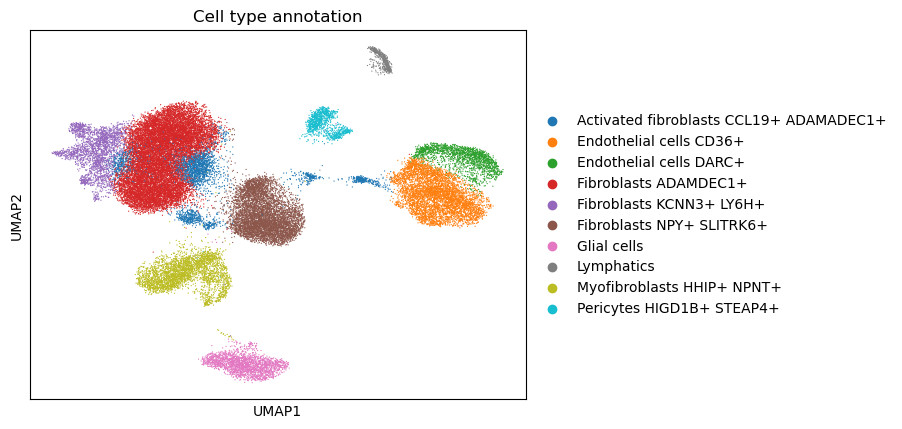

In [35]:
sc.pl.umap(adata_CO, color=['cell_type'], legend_loc='right margin', title='Cell type annotation')

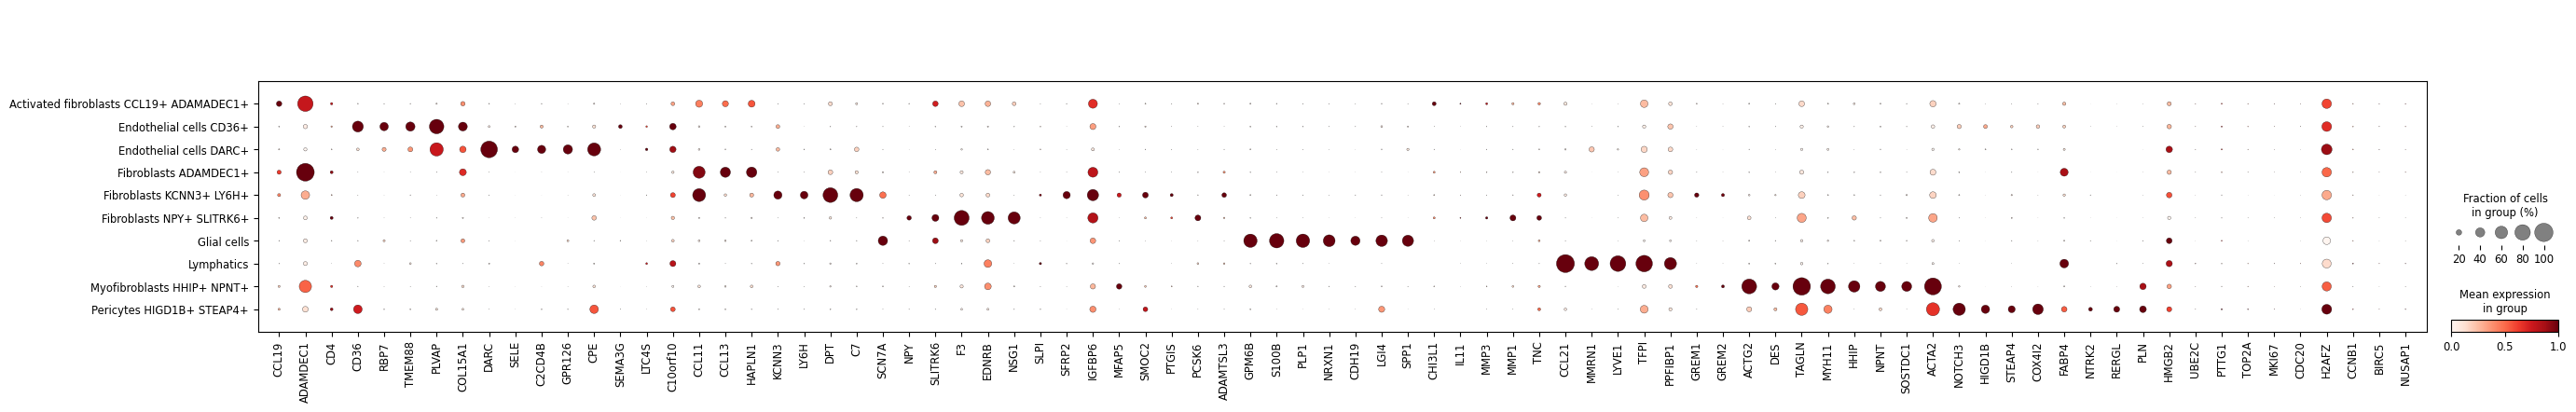

In [38]:
sc.pl.dotplot(
    adata_CO,
    var_names=marker_genes,
    groupby='cell_type',  # 또는 'leiden'
    standard_scale='var',  # 클러스터별로 발현 스케일링
    dendrogram=False
)

CO_STR_GLIA

In [39]:
print(adata_CO.obs['cell_type'].unique())

['Fibroblasts ADAMDEC1+', 'Endothelial cells CD36+', 'Lymphatics', 'Endothelial cells DARC+', 'Pericytes HIGD1B+ STEAP4+', 'Glial cells', 'Myofibroblasts HHIP+ NPNT+', 'Activated fibroblasts CCL19+ ADAMADEC1+', 'Fibroblasts NPY+ SLITRK6+', 'Fibroblasts KCNN3+ LY6H+']
Categories (10, object): ['Activated fibroblasts CCL19+ ADAMADEC1+', 'Endothelial cells CD36+', 'Endothelial cells DARC+', 'Fibroblasts ADAMDEC1+', ..., 'Glial cells', 'Lymphatics', 'Myofibroblasts HHIP+ NPNT+', 'Pericytes HIGD1B+ STEAP4+']


In [41]:
gbarcodes = adata_CO[adata_CO.obs['cell_type'] == 'Glial cells'].obs_names
gbarcodes

Index(['N105446_L-GCTACCTTCCGATAAC', 'N110204_L-CAGATACTCTAGTGAC',
       'N110204_L-AGGACTTGTGTTTCTT', 'N110204_L-TGTCAGAAGTCGCTAT',
       'N110204_L-TTAGGGTTCCTGTAGA', 'N110204_L-CTCATGCCAGGGTTGA',
       'N110204_L-ATGCATGTCCGATCTC', 'N110204_L-CTGCCTAGTTACGATC',
       'N110204_L-AACGGGATCGCTTGCT', 'N110204_L-CAGCCAGGTAAGGCTG',
       ...
       'N130084_L-AGTCAACAGTCGGCCT', 'N130084_L-GCATGATAGAAGCCTG',
       'N130084_L-CCGCAAGTCAACCGAT', 'N130084_L-GAAACCTTCTCGTCAC',
       'N130084_L-GAGACCCTCATCCTGC', 'N130084_L-GCTGGGTCAGAGCTAG',
       'N130084_L-CTACCTGCACGTCTCT', 'N130084_L-GATGAGGGTGGGATTG',
       'N130084_L-CTTGATTGTACGATGG', 'N130084_L-TTCGCTGTCATCGTAG'],
      dtype='object', length=2170)

In [43]:
gadata_CO

AnnData object with n_obs × n_vars = 39433 × 28663
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [44]:
gadata_CO = gadata_CO[gadata_CO.obs_names.isin(gbarcodes)]

In [46]:
gadata_CO

View of AnnData object with n_obs × n_vars = 2170 × 28663
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [47]:
gadata_CO.obs['batch'] = gadata_CO.obs_names.str.split('_').str[0]

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_12504\692328693.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gadata_CO.obs['batch'] = gadata_CO.obs_names.str.split('_').str[0]


In [50]:
sc.pp.highly_variable_genes(gadata_CO, n_top_genes=2000)
gadata_CO.raw = gadata_CO.copy()
gadata_CO = gadata_CO[:, gadata_CO.var.highly_variable].copy()

C:\Anaconda3\envs\NIM_Kim\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


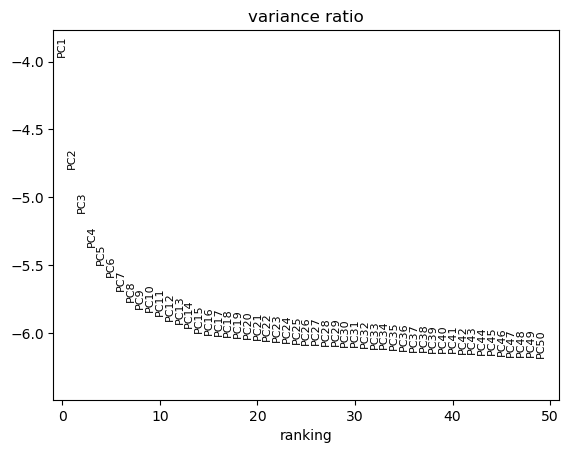

In [52]:
sc.pp.scale(gadata_CO, max_value=10)
sc.tl.pca(gadata_CO, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata_CO, log=True, n_pcs = 50)

In [53]:
sc.external.pp.harmony_integrate(gadata_CO, key='batch', max_iter_harmony = 20)
sc.pp.neighbors(gadata_CO, n_neighbors = 10, n_pcs = 15, use_rep='X_pca_harmony')
sc.tl.umap(gadata_CO)

2025-07-23 14:24:08,705 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
2025-07-23 14:24:09,485 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-23 14:24:09,498 - harmonypy - INFO - Iteration 1 of 20
2025-07-23 14:24:10,809 - harmonypy - INFO - Iteration 2 of 20
2025-07-23 14:24:12,125 - harmonypy - INFO - Iteration 3 of 20
2025-07-23 14:24:13,167 - harmonypy - INFO - Iteration 4 of 20
2025-07-23 14:24:14,037 - harmonypy - INFO - Iteration 5 of 20
2025-07-23 14:24:14,885 - harmonypy - INFO - Iteration 6 of 20
2025-07-23 14:24:15,580 - harmonypy - INFO - Iteration 7 of 20
2025-07-23 14:24:16,356 - harmonypy - INFO - Iteration 8 of 20
2025-07-23 14:24:17,075 - 

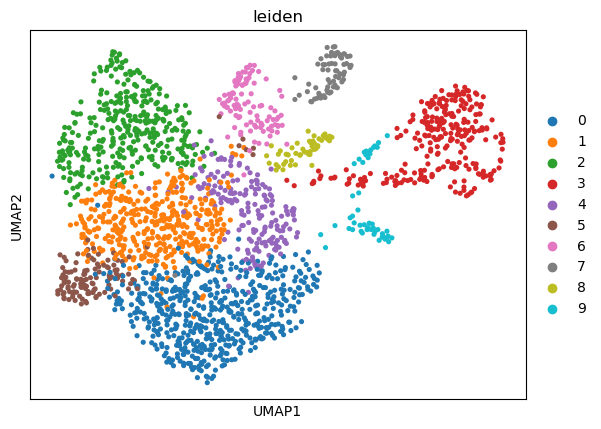

In [55]:
sc.tl.leiden(gadata_CO, resolution = 0.5)
sc.pl.umap(gadata_CO, color=['leiden'])

In [56]:
glial_markers = {
    "Canonical EGC": ["GFAP", "PLP1", "SOX10", "S100B"],
    "Neurogenic-primed": ["ASCL1", "PHOX2B", "NES"],
    "Immune-reactive": ["ISG15", "IFI44L", "CD74"],
    "ECM-rich": ["COL20A1", "BCAN", "FBLN2"]
}